# Assignment 3

For submission, please choose "file"->"Download"->"Download .py", rename the file to "firstname_lastname.py" and upload it on the iCorsi platform. While we encourage you to discuss the assignments in groups, please write all the code yourself and do not share it with others! The deadline is Monday December 2th, 11:59 pm.

For everything to work, all the cells in this notebook have to run in the correct order. When in doubt, just choose "Runtime"->"Run all" and it will run all cells from the start until an exception is encountered.

For comments and questions, contact me: vincent.herrmann@usi.ch


# Simple Machine Learning Framework
(30 points)

In this part we are going to implement a very simple machine learning framework. The goal is that at the end of this part, you will have a rough idea what is happening inside a real world ML framework (e.g. PyTorch, TensorFlow, JAX, etc). Using this framework you will be able to easily build and train arbitrary fully connected neural networks. It will have the following building blocks: linear layer, sequential layer, the tanh activation function, and the softmax + cross-entropy loss. The skeleton is given, you will have to fill in the missing parts. Pay attention to the description in the skeleton file: it clarifies the task further, and also gives some useful hints. **You are not allowed to change the signature of the functions (name, the format of the arguments or output)**. They will be auto-checked, so their interface should match.

You will test your framework on a synthetic two-class spiral dataset. You will use a simple, 3 layer network with tanh activation function on hidden layers and a softmax output layer. The output sizes are 50, 30, 2, respectively.

- (5 points) Implement the ReLU activation function and its derivative in the code skeleton.

- (5 points) Implement forward and backward pass for the linear layer.

- (10 points) Implement forward and backward pass for the cross-entropy loss.

- (10 points) Create the network and implement a single step of training with weight decay.

Your task is to fill missing parts of this notebook.

### Detailed instructions
You will have to implement a very primitive machine learning framework. The skeleton is given. You have to fill the
blocks starting with `## Implement` and ending with `## End`. The goal is to provide you an insight into how machine learning frameworks work
while practicing the most important details from the class.

You have to implement the following modules (or call them layers?):
- The ReLU activation function
- A learnable linear layer
- The Softmax+Cross-Entropy loss

The linear layer is also called perceptron, fully connected layer, etc. The bias term is not included in the
network weight matrix W because of performance reasons (concatenating the 1 to the input is slow). This is the case for the real-world ML frameworks too.

All the functions you have to implement has their signature pre-specified, with annotated types. You should _not_ change this, because it will be tested by an automated system which depends on the current interface.

The sequential layer is already implemented. It receives a list of layers for the constructor argument, and calls them in order on forward and in reverse order on backward. It is just syntactic sugar that makes the code much nicer. For example, you can
create a two-layer neural network with ReLU activation functions with `net = Sequential([Linear(5, 8), ReLU(),
Linear(8, 3), ReLU()])` and then run a forward pass using `output = net.forward(your data)`.

All the modules have a `forward()` and a `backward()` function. `forward()` receives one argument (except for the loss which takes two) and
returns that layer's output. The `backward()` receives the dL/dout (i.e., the gradient of the loss with respect to the output of the last `forward()` call), flowing back on the output of the layer, and should return a `BackwardResult` object with the following fields:
- `variable_grads`: a dict of gradients, where the keys are the same as in the keys in the layer's .var. The values are numpy arrays representing the gradient for that variable.
- `input_grads`: a numpy array representing the gradient for the input (that was passed to the layer in the forward pass).

The `backward()` does not receive the forward pass's input, although it might be needed for the gradient calculation. You should save them in the forward pass for later use in the backward pass. You don't have to worry about most of this, as it is already implemented in the skeleton. There are 2 important takeaways: you have to calculate the gradient of both of your variables and the layer input in the backward pass, and if you need to reuse the input from the forward pass, you need to save it.

You will also have to implement the function `train_one_step()`, which does one step of weight update based on the training data and the learning rate. It should run backpropagation, followed by gradient descent. It should also include weight decay, meaning that weights and biases are being punished for being too large. This equivalent to having an additional loss term $L_{wd} = \beta \sum_l \big(|w_l|^2 + |b|^2 \big)$, where $\beta$ is the weight decay factor and $l$ is the index of the layer. It is easiest to implement it directly in the `train_one_step()` function. A good value for $\beta$ is $0.005$.

Automatic gradient checking is already implemented. It works by comparing your implementation of the analytic gradient with a numerical approximation. This is done by iterating over all the elements of all variables, nudging them a bit in both directions, and recalculating the network output. Based on that, we can calculate what the gradient should be if we assume that the forward pass is correct. The method is known as numerical differentiation, specifically the symmetric difference quotient. If the gradient checking passes and the error is around 0.008, your implementation of the backward passes is probably correct.

Finally, you would have to complete the `create_network()` function, which should return a Sequential neural network of 3 layers: a ReLU input layer with 2 inputs and 50 outputs, a ReLU hidden layer with 30 outputs, and finally an output layer with 2 outputs. Our loss function is the Softmax+Cross-Entropy loss. Usually for two-way classification we don't use softmax, but we will need it for the MNIST part anyway, so we use it here as well.

At the end of the training, your loss should be below 0.04. Don't worry if it differs a bit, but a significantly higher value may indicate a problem.

There are asserts at many points in the code that will check the shapes of the gradients. Remember: the gradient for a variable must have the same shape as the variable itself. Imagine the variables and the network inputs/outputs as a cable with a given number of wires: no matter in which direction you pass the data, the number of wires is the same.

Please do your calculations in a vectorized way. Otherwise, it will be painfully slow. This also means your data has a batch dimension. The input to each module is not a data vector $x$, but a $n \times d$ matrix, where $n$ is the batch size and $d$ the dimensionality of the data vector. The only places where you might need a for-loop are the `Sequential` layer and the `train_one_step` function.

Good luck, I hope you'll enjoy it :)!

In [107]:
###############################################################################################################
# Nothing to do in this cell.
###############################################################################################################


import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from urllib import request
import gzip

%matplotlib inline

# Interface definitions
class Layer:
    var: Dict[str, np.ndarray] = {}

    @dataclass
    class BackwardResult:
        variable_grads: Dict[str, np.ndarray]
        input_grads: np.ndarray

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    def backward(self, error: np.ndarray) -> BackwardResult:
        raise NotImplementedError()


class Loss:
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError()

    def backward(self) -> np.ndarray:
        raise NotImplementedError()

### ReLU Activation Function

In [108]:
class ReLU(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        result = np.maximum(0, x)
        self.saved_variables = {"result": result}
        return result

    def backward(self, grad_in: np.ndarray) -> Layer.BackwardResult:
        # result of forward pass, needed to compute the derivative of ReLu(X) -> ReLu'(X)
        relu_x = self.saved_variables["result"]
        # Derviative of ReLU: f'(x) = 1 if x > 0 else 0
        d_x = np.where(relu_x > 0, 1, 0) * grad_in

        # ensure dimensions match
        assert d_x.shape == relu_x.shape, "Input: grad shape differs: %s %s" % (d_x.shape, relu_x.shape)
        
        # Clean up internal state + return backward result
        self.saved_variables = None
        return Layer.BackwardResult({}, d_x)

### Linear Layer

In [109]:
class Linear(Layer):
    def __init__(self, input_size: int, output_size: int):
        self.var = {
            "W": np.random.normal(0, np.sqrt(2 / (input_size + output_size)), (input_size, output_size)),
            "b": np.zeros((output_size), dtype=np.float32)
        }

    def forward(self, x: np.ndarray) -> np.ndarray:
        W = self.var['W'] # weights
        b = self.var['b'] # bias

        # Compute the linear transformation of x
        y =  np.dot(x, W) + b

        # Save the input for the backward pass
        self.saved_variables = {
            "input": x,
        }

        # return the result
        return y

    def backward(self, grad_in: np.ndarray) -> Layer.BackwardResult:
        W = self.var['W'] # weights
        x = self.saved_variables["input"]

        ## Implement

        dW = np.dot(x.T, grad_in)
        db = np.sum(grad_in, axis=0)
        d_inputs = np.dot(grad_in, W.T)

        # ensure dimensions match
        assert d_inputs.shape == x.shape, "Input: grad shape differs: %s %s" % (d_inputs.shape, x.shape)
        assert dW.shape == self.var["W"].shape, "W: grad shape differs: %s %s" % (dW.shape, self.var["W"].shape)
        assert db.shape == self.var["b"].shape, "b: grad shape differs: %s %s" % (db.shape, self.var["b"].shape)

        self.saved_variables = None
        updates = {"W": dW,
                   "b": db}
        return Layer.BackwardResult(updates, d_inputs)

### Sequential Layer

In [110]:
###############################################################################################################
# Nothing to do in this cell.
###############################################################################################################


class Sequential(Layer):
    class RefDict(dict):
        def __setitem__(self, k, v):
            assert k in self, "Trying to set a non-existing variable %s" % k
            ref = super().__getitem__(k)
            ref[0][ref[1]] = v

        def __getitem__(self, k):
            ref = super().__getitem__(k)
            return ref[0][ref[1]]

        def items(self) -> Tuple[str, np.ndarray]:
            for k in self.keys():
                yield k, self[k]

    def __init__(self, list_of_modules: List[Layer]):
        self.modules = list_of_modules

        refs = {}
        for i, m in enumerate(self.modules):
            print(f"mod_{i}: {m}")
            refs.update({"mod_%d.%s" % (i,k): (m.var, k) for k in m.var.keys()})

        self.var = self.RefDict(refs)

    def forward(self, input: np.ndarray) -> np.ndarray:
        x = input
        for i, m in enumerate(self.modules):
            x = m.forward(x)
        return x

    def backward(self, grad_in: np.ndarray) -> Layer.BackwardResult:
        variable_grads = {}

        for module_index in reversed(range(len(self.modules))):
            module = self.modules[module_index]

            grads = module.backward(grad_in)

            grad_in = grads.input_grads
            variable_grads.update({"mod_%d.%s" % (module_index, k): v for k, v in grads.variable_grads.items()})

        return Layer.BackwardResult(variable_grads, grad_in)

### Softmax + Cross-Entropy Loss

In [111]:
class SoftmaxCrossEntropy(Loss):
    def forward(self, inputs: np.ndarray, targets: np.ndarray) -> float:
        y = inputs
        t = targets
        n = inputs.shape[0]
        num_classes = y.shape[1]

        ## Remember that the here targets are not one-hot vectors, but integers specifying the class.
        ## The loss function has to return a single scalar, so we have to take the mean over the batch dimension.
        ## Don't forget to save your variables needed for backward to self.saved_variables.

        # Convert the target indices to one-hot vectors

        # Matrix (n, num_classes) with all zeros
        one_hot_t = np.zeros((n, num_classes))

        # For each class, we set the corresponding index to 1
        for i in range(n):
            one_hot_t[i, t[i]] = 1

        # Numerically stable softmax computation
        # Source: https://www.parasdahal.com/softmax-crossentropy

        # Compute the softmax
        shifted_logits = y - np.max(y, axis=1, keepdims=True)
        exp_shifted = np.exp(shifted_logits)
        softmax = exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

        # Compute the cross-entropy loss
        # H(y, softmax) = - sum(t * log(softmax))
        mean_crossentropy = -np.sum(one_hot_t * np.log(softmax)) / n

        self.saved_variables = {
            "S": softmax,
            "t": one_hot_t,
            "n": n
        }

        return mean_crossentropy

    def backward(self) -> np.ndarray:
        softmax = self.saved_variables["S"]
        one_hot_t = self.saved_variables["t"]
        n = self.saved_variables["n"]

        ## Implement

        # To compute the gradient of the cross-entropy loss with respect to the input of the softmax layer,
        # we can use the following formula:
        # dL/dy = softmax - t

        d_inputs = (softmax - one_hot_t) / n

        ## End

        assert d_inputs.shape == softmax.shape, f"Error shape doesn't match prediction: {d_inputs.shape} {softmax.shape}"
        self.saved_variables = None
        return d_inputs

### Train One Step & Create Network Functions

In [112]:
def train_one_step(model: Layer, loss: Loss, learning_rate: float, input: np.ndarray, target: np.ndarray, weight_decay=0.0005) -> float:

    ## Implement
    ## Calculate the loss value for the given inputs and targets, calculate the
    ## gradients via backpropagation, and update all the weights and biases via
    ## gradient descent (use a for-loop to go through all the learnable
    ## parameters of the model)

    # Forward pass
    pred = model.forward(input)

    # Compute loss value (using loss function passed as parameter)
    loss_value = loss.forward(pred, target)

    # Compute loss function gradient: dL/dy
    loss_gradients = loss.backward()

    # Compute gradient of each learnable parameter (weights and biases)
    back_results = model.backward(loss_gradients)
    _input_grads = back_results.input_grads # Should we need this? 
    variable_gradients = back_results.variable_grads

    # Update the weights and biases 
    for key, grad in variable_gradients.items():
        # Apply weight decay (L2 regularization)
        grad += weight_decay * model.var[key]
        # Update the weights and biases
        model.var[key] -= learning_rate * grad
    ## End

    return loss_value


def create_network() -> Layer:

    ## Implement

    network = Sequential([
        Linear(2, 20), 
        Linear(20, 50), ReLU(),    # Input layer (2D spiral data) with a larger hidden layer
        Linear(50, 30), ReLU(),   # Second hidden layer
        Linear(30, 2)             # Output layer for classification
    ])

    ## End

    return network

### Gradient Checking

In [113]:
###############################################################################################################
# Nothing to do in this cell.
###############################################################################################################

def gradient_check():
    X, T = twospirals(n_points=10)
    print(X.shape, T.shape)
    NN = create_network()
    eps = 0.0001

    loss = SoftmaxCrossEntropy()
    loss.forward(NN.forward(X), T)
    variable_gradients = NN.backward(loss.backward()).variable_grads

    all_succeeded = True

    # Check all variables. Variables will be flattened (reshape(-1)), in order to be able to generate a single index.
    for key, value in NN.var.items():
        variable = NN.var[key].reshape(-1)
        variable_gradient = variable_gradients[key].reshape(-1)
        success = True

        if NN.var[key].shape != variable_gradients[key].shape:
            print("[FAIL]: %s: Shape differs: %s %s" % (key, NN.var[key].shape, variable_gradients[key].shape))
            success = False
            break

        # Check all elements in the variable
        for index in range(variable.shape[0]):
            var_backup = variable[index]

            analytic_grad = variable_gradient[index]

            variable[index] = var_backup + eps
            perturbed_loss_plus = loss.forward(NN.forward(X), T)
            variable[index] = var_backup - eps
            perturbed_loss_minus = loss.forward(NN.forward(X), T)
            numeric_grad = (perturbed_loss_plus - perturbed_loss_minus) / (2*eps)

            variable[index] = var_backup
            if abs(numeric_grad - analytic_grad) > 0.00001:
                print("[FAIL]: %s: Grad differs: numerical: %f, analytical %f" % (key, numeric_grad, analytic_grad))
                success = False
                break

        if success:
            print("[OK]: %s" % key)

        all_succeeded = all_succeeded and success

    return all_succeeded

### Train Model

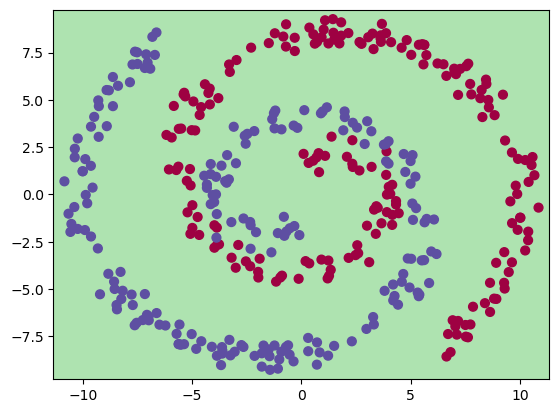

step:  0  cost:  0.8565466560448266


KeyboardInterrupt: 

In [114]:
###############################################################################################################
# Nothing to do in this cell. Run it to train your model.
###############################################################################################################

np.random.seed(12345)


def twospirals(n_points=120, noise=1.4, twist=600):
    """
      Returns a two spirals dataset.
    """
    np.random.seed(0)
    n = np.sqrt(np.random.rand(n_points, 1)) * twist * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    X, T = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points).astype(int), np.ones(n_points).astype(int))))
    return X, T


def plot_data(X, T):
    ax.scatter(X[:, 0], X[:, 1], s=40, c=T, cmap=plt.cm.Spectral)


def plot_boundary(model, X, targets, threshold=0.0):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    y = model.forward(X_grid)[:, 0]

    ax.contourf(xx, yy, y.reshape(*xx.shape) < threshold, alpha=0.5)
    plot_data(X, targets)
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    plt.show()


print("Checking the network")
if not gradient_check():
    raise Exception("Failed. Not training, because your gradients are not good.")
print("Done. Training...")

X, T = twospirals(n_points=200, noise=1.4, twist=600)
NN = create_network()
loss = SoftmaxCrossEntropy()

learning_rate = 0.02

for i in range(20000):
    curr_error = train_one_step(NN, loss, learning_rate, X, T, weight_decay=0.0005)
    if i % 200 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots()

        plot_boundary(NN, X, T, 0.5)
        print("step: ", i, " cost: ", curr_error)

# Handwritten Digit Recognition

(20 points)

In this part you will use your ML framework to train a network that can classify handwritten digits. The network is a very simple 2 layer network, with layer output sizes of 20 and 10 respectively. Again, the skeleton is given, and you have to fill in the missing parts. After this part, you will have a rough idea how to build a proper training pipeline. Pay attention to the description in the skeleton file: it clarifies the your task further, and also gives some useful hints. Reuse as much as you can from framework.py by importing the corresponding functions and classes (e.g the layers, the `train_one_step()` function, etc).

- (3 points) Split the data into a training and a validation set.  
- (8 points) Implement one function for testing the network on the validation set and one for testing it on the test set.
- (6 points) Implement the main training loop.
- (3 points) Implement early stopping.

Your task is to fill missing parts of the minst.py file. Run it with Python 3 in order to verify whether your solution is correct. Note: The mnist.py and framework.py must be in the same folder for this to work. You will find lots of hints in the templates. Note: in case you return wrongly shaped vectors, the code might fail outside the part you had to fill, but this does not mean that your part is right and the template is wrong.

### Detailed Instructions
In this assignment, you will learn how to train a model with early stopping with the simple machine learning
framework's help from the previous assignment. The intent is to show you how to train a machine learning model.
It is very similar to what you would do in a real ML framework.

We provide some code to download and load MNIST digits. The MNIST comes with a separate test and training set, but
not a validation set. Your task is to split the official "train" set to train and validation set and train the
network with early stopping.

Some notes:
 * an EPOCH is a pass through the whole training set once.
 * validation accuracy is the percentage of correctly classified digits on the validation set.
 * early stopping is when you avoid overfitting the model by measuring validation accuracy every N steps (e.g.,
   every epoch) and stopping your training when your model begins to worsen on the validation set. You can do that by
   keeping track of the best validation accuracy so far and its epoch, and stopping if the validation
   accuracy has not improved in the last M steps (e.g., last 10 epochs).
   (A better way to do this is to keep the weights of the best performing model, but that is harder since you need a
   way to save and reload weights of the model. We keep it simple instead and use the last, slightly worse model).
 * test accuracy is the percentage of correctly classified digits on the test set.
 * watch out: if you load batch_size of data by NumPy slicing, it is not guaranteed that you will actually get
   batch_size of them: if your array length is not divisable by batch_size, you will get the remainder as the last
   batch. Take that in account when calculating the percentages: use shape[0] to determine the real number of
   elements in the current batch of data.
 * verify() should be used both in the validate() and test() functions for error measurement
   without code duplication (just the input data should be different).
 * this is a 10-way classification task, so your network will have 10 outputs, one for each digit. It
   can be trained by Softmax nonlinearity followed by a Cross-Entropy loss function. So for every image, you get 10
   outputs. To figure out which one is the correct class, you should find which is the most active.
 * MNIST comes with black-and-white binary images, with a background of 0 and foreground of 255. Each image is 28x28
   matrix. To feed that to the model, we flatten it to a 784 (28*28) length vector and normalize it by 255, so the
   backround becomes 0 and the foreground 1.0. Labels are integers between 0-9. You don't have to worry about this;
   it's already done for you. The networks usually like to receive an input in range -1 .. 1 or generally the mean
   near 0, and the standard deviation near 1 (as the majority of MNIST pixels is black, normalizing it to 0..1 range
   is good enough).

Your final test accuracy should be close to 96%.

Good luck!

In [119]:
#######################################################################################################################
# Nothing to do in this cell.
#######################################################################################################################

class MNIST:
    URL = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"

    def __init__(self, set, cache="./cache"):
        os.makedirs(cache, exist_ok=True)

        path = os.path.join(cache, "mnist.npz")
        if not os.path.isfile(path):
            request.urlretrieve(self.URL, path)

        data = np.load(path)

        assert set in ["train", "test"], "set must be either train or test"

        self.images = data["x_" + set].astype(float) / 255.0
        self.labels = data["y_" + set]

    def __len__(self) -> int:
        return self.images.shape[0]


train_validation_set = MNIST("train")
test_set = MNIST("test")

n_train = int(0.7 * len(train_validation_set))
print("MNIST:")
print("   Train set size:", n_train)
print("   Validation set size:", len(train_validation_set) - n_train)
print("   Test set size", len(test_set))

np.random.seed(1234)
batch_size = 64

loss = SoftmaxCrossEntropy()
learning_rate = 0.1

model = Sequential([
    Linear(28*28, 20),
    ReLU(),
    Linear(20, 10),
])

MNIST:
   Train set size: 42000
   Validation set size: 18000
   Test set size 10000
mod_0: <__main__.Linear object at 0x11f73e250>
mod_1: <__main__.ReLU object at 0x11fb3d090>
mod_2: <__main__.Linear object at 0x2a56e7810>


### Train-Validation Split

In [120]:
indices = np.random.permutation(len(train_validation_set))

## Implement
## Hint: you should split indices to 2 parts: a training and a validation one. Later when loading a batch of data,
## just iterate over those indices by loading "batch_size" of them at once, and load data from the dataset by
## train_validation_set.images[your_indices[i: i+batch_size]] and
## train_validation_set.labels[your_indices[i: i+batch_size]]

train_indices = indices[:n_train]
validation_indices = indices[n_train:]

## End

### Verify, Test and Validate Functions

In [125]:
def verify(images: np.ndarray, targets: np.ndarray) -> Tuple[int, int]:
    # NOTE: "images" is simply the output of the forward pass of the model (scores for each image!)

    ## Implement

    # Check is the prediction is correct
    # NOTE: The maximum value in the probability vector is the class chosen by the model
    #       argmax --> return the index of the maximum value == predicted class by the model
    is_correct = np.argmax(images, axis=1) == targets
    num_ok = np.sum(is_correct)

    # Total number of images
    total_num = targets.shape[0]

    ## End
    return num_ok, total_num


def test() -> float:
    accumulated_ok = 0.0
    count = 0

    for i in range(0, len(test_set), batch_size):
        images = train_validation_set.images[i:i + batch_size]
        labels = train_validation_set.labels[i:i + batch_size]

        ## Implement. Use the verify() function to verify your data.
        num_ok, total_num = verify(images, labels)
        accumulated_ok += num_ok
        count += total_num
        ## End

    return accumulated_ok / count * 100.0


def validate() -> float:
    accumulated_ok = 0.0
    count = 0

    for i in range(0, len(train_validation_set), batch_size):
        images = train_validation_set.images[i:i + batch_size]
        labels = train_validation_set.labels[i:i + batch_size]

        ## Implement. Use the verify() function to verify your data.
        num_ok, total_num = verify(images, labels)
        accumulated_ok += num_ok
        count += total_num
        ## End

    return accumulated_ok/count * 100.0

### Train Loop with Early Stopping

In [129]:
## You should update these: best_validation_accuracy is the best validation set accuracy so far, best_epoch is the
## epoch of this best validation accuracy (the later can be initialized by anything, as the accuracy will be for sure
## better than 0, so it will be updated for sure).
best_validation_accuracy = 0
best_epoch = -1

for epoch in range(200):
    ## Implement
    ## Use a for-loop to go through all the mini-batches (with the given batch
    ## size) in the training set, then compute the validation accuracy using
    ## validate()

    # Train the model using the training set
    train_set = train_validation_set.images[train_indices]
    target = train_validation_set.labels[train_indices]

    print("Training set shape: ", train_set.shape)
    
    count = 0
    total_ok = 0
    for i in range(0, len(train_set), batch_size):
        # train data: 64 images (28x28 pixels) --> 64x28x28
        # reshape the data to 64x784 (inline image)
        flat_train_batch = train_set[i: i+batch_size].reshape(
            batch_size, # 64 images still
            -1 # the required number of columns (784 = 28x28)
        )
        target_batch = target[i: i+batch_size]

        print("Epoch %d, batch %d/%d, training set shape: %s" % (epoch, i, len(train_set), flat_train_batch.shape))

        pred_labels = model.forward(flat_train_batch) # forward pass on one batch
        
        # Compute loss on the batch
        current_loss_value = loss.forward(pred_labels, target_batch)
        # count the number of correct predictions
        num_ok, total_num = verify(pred_labels, target_batch)
        total_ok += num_ok
        count += total_num

    # Compute the accuracy of the model on the training set
    validation_accuracy = total_ok / count * 100.0

    ## End

    print("Epoch %d: loss: %f, validation accuracy: %.2f%%" % (epoch, current_loss_value, validation_accuracy))

    ## Implement
    ## Hint: you should check if current accuracy is better that the best so far. If it is not, check before how many
    ## iterations ago the best one came, and terminate if it is more than 10. Also update the best_* variables
    ## if needed.

    # End

print("Test set performance: %.2f%%" % test())

Training set shape:  (42000, 28, 28)
Epoch 0, batch 0/42000, training set shape: (64, 784)
Epoch 0, batch 64/42000, training set shape: (64, 784)
Epoch 0, batch 128/42000, training set shape: (64, 784)
Epoch 0, batch 192/42000, training set shape: (64, 784)
Epoch 0, batch 256/42000, training set shape: (64, 784)
Epoch 0, batch 320/42000, training set shape: (64, 784)
Epoch 0, batch 384/42000, training set shape: (64, 784)
Epoch 0, batch 448/42000, training set shape: (64, 784)
Epoch 0, batch 512/42000, training set shape: (64, 784)
Epoch 0, batch 576/42000, training set shape: (64, 784)
Epoch 0, batch 640/42000, training set shape: (64, 784)
Epoch 0, batch 704/42000, training set shape: (64, 784)
Epoch 0, batch 768/42000, training set shape: (64, 784)
Epoch 0, batch 832/42000, training set shape: (64, 784)
Epoch 0, batch 896/42000, training set shape: (64, 784)
Epoch 0, batch 960/42000, training set shape: (64, 784)
Epoch 0, batch 1024/42000, training set shape: (64, 784)
Epoch 0, batc

ValueError: shapes (64,196) and (784,20) not aligned: 196 (dim 1) != 784 (dim 0)